Primeiro vamos importar o dataset para a variável dts

In [1]:
import pandas as pd
dts = pd.read_csv('data.csv')

Precisamos dar uma olhada nesse dataset para entendermos quais os tipos de dados que ele possui

In [2]:
dts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Em resumo, todos os dados são números com excessão do coluna diagnosis, vamos entender do que se trata?

In [3]:
set(dts["diagnosis"])

{'B', 'M'}

O dataset em questão trata os tipos de tumores, dessa forma temos o valor "B" para Benigno e "M" para Maligno, precisaremos alterá-los para números para podermos tratá-los corretamente no futuro.

Também é interessante entendermos como esses valores estão distribuídos no dataset para enterdemos se há algum tipo de assimetria muito grande nos dados, vamos ver uma descrição desse dataset

In [4]:
print(dts.describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

Com isso já temos muitas informações dos valores, incluindo uma muito importante, count, que por conta de ela ter o valor igual em todos as features, podemos ver que esse dataset possui todas as tabelas preenchidas, e não há nenhum valor faltante nas colunas, mas infelizmente é um banco bem pequeno, o que pode enviezar o nosso modelo em quantidades mais elevadas de dados.

Também vamos realizar uma visualização mais gráfica para entender se há algum dado muito unilateral no dataset

array([[<Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'perimeter_mean'}>,
        <Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'smoothness_mean'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'concave points_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>,
        <Axes: title={'center': 'fractal_dimension_mean'}>],
       [<Axes: title={'center': 'radius_se'}>,
        <Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'perimeter_se'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'smoothness_se'}>],
       [<Axes: title={'center': 'compactness_se'}>,
        <Axes: title={'center': 'concavity_se'}>,
        <Axes: title={'center': 'concave points_se'}>,
        <Axes: title={'center': 'symmetry_se'}>,
        <Axes: title={'ce

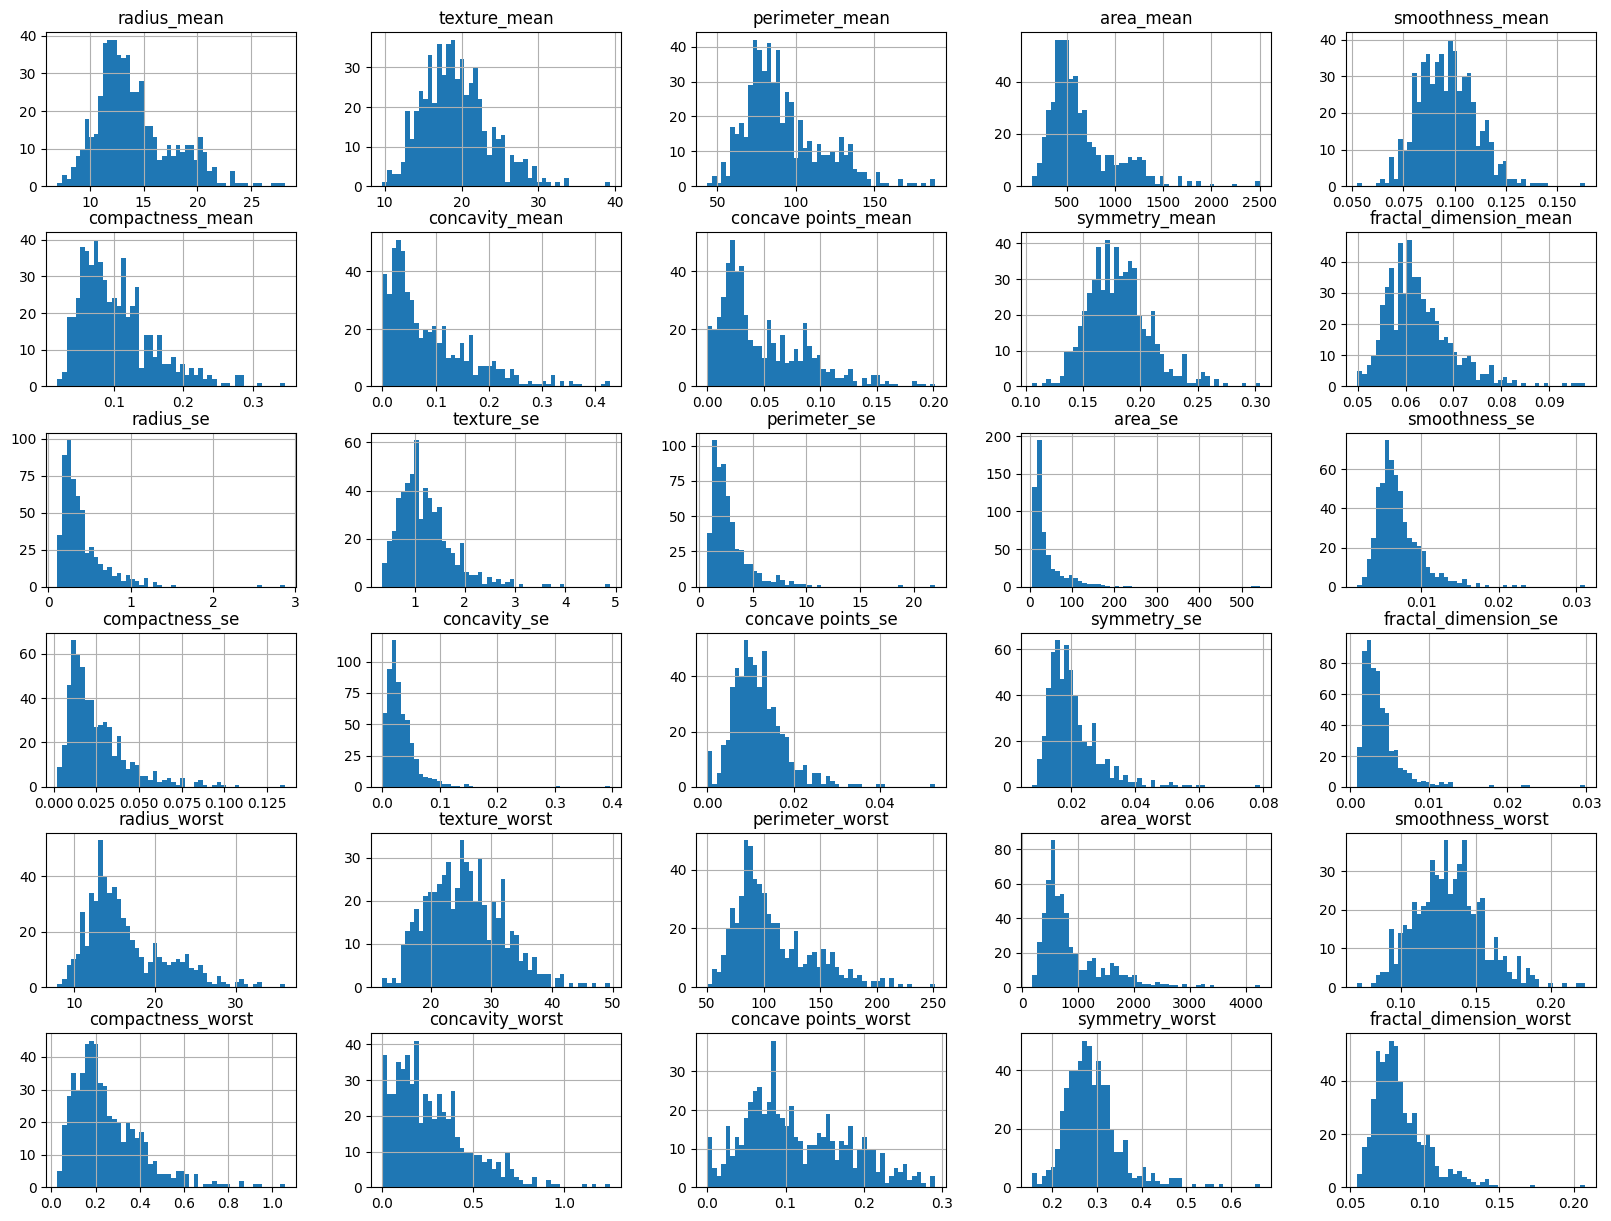

In [5]:
dts.hist(bins=50, figsize=(20,15))

Podermos ver que a maioria desses dados desse dataset já foram tratados anteriormente, o que facilitará nosso processo de análise e treino, porém, por ser um dataset muito pequeno, não será possível darmos um tratamento mais eficiente em algumas features, pois corremos um risco muito alto de overfiting caso realizemos esse tratamento

Agora sim vamos começar. Primeiro vamos separar a coluna "diagnosis" das outras pois ela é a nossa target já que possuí o resultado, também vamos adicionar as outras colunas como sendo nossa feature.

In [6]:
target_column = 'diagnosis'
X = dts.drop(columns=[target_column])
y = dts[target_column]

Também vamos aproveitar para remapear a coluna diagnosis para valores numéricos, nesse caso, vamos configurá-la para "0" como sendo Benigno e "1" como sendo "Maligno"

In [7]:
y = y.map({'B': 0, 'M': 1})

Para podermos configurar a pipeline, vamos adicionar todos os valores númericos restantes, para a nossa nova variável

In [8]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

Antes de treinarmos nossos modelos, vamos verificar se existe alguma correlação nos dados?

In [9]:
df_corr_target = pd.concat([X, y], axis=1)
corr_matrix  = df_corr_target.corr()

Vamos verificar se algum dos dados estão correlacionados com a nossa feature mais importante, a 'diagnosis'

In [10]:
corr_diagnosis = corr_matrix[target_column].sort_values(ascending=False)
print(corr_diagnosis)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

Podemos ver que existe uma correlação similar na maioria dos dados, não uma que se destaca das outras, isso pode ser por conta do nosso dataset ser muito pequeno, o que pode causar esse tipo de correlação entre os dados, outra motivação pode ser por se tratar de algo biológico como o câncer, onde não temos um motivo específico para que ele aconteça, e sim uma junção de fatores que podem ou não causar a doença

E os outros dados, será que existem uma correlação entre eles?

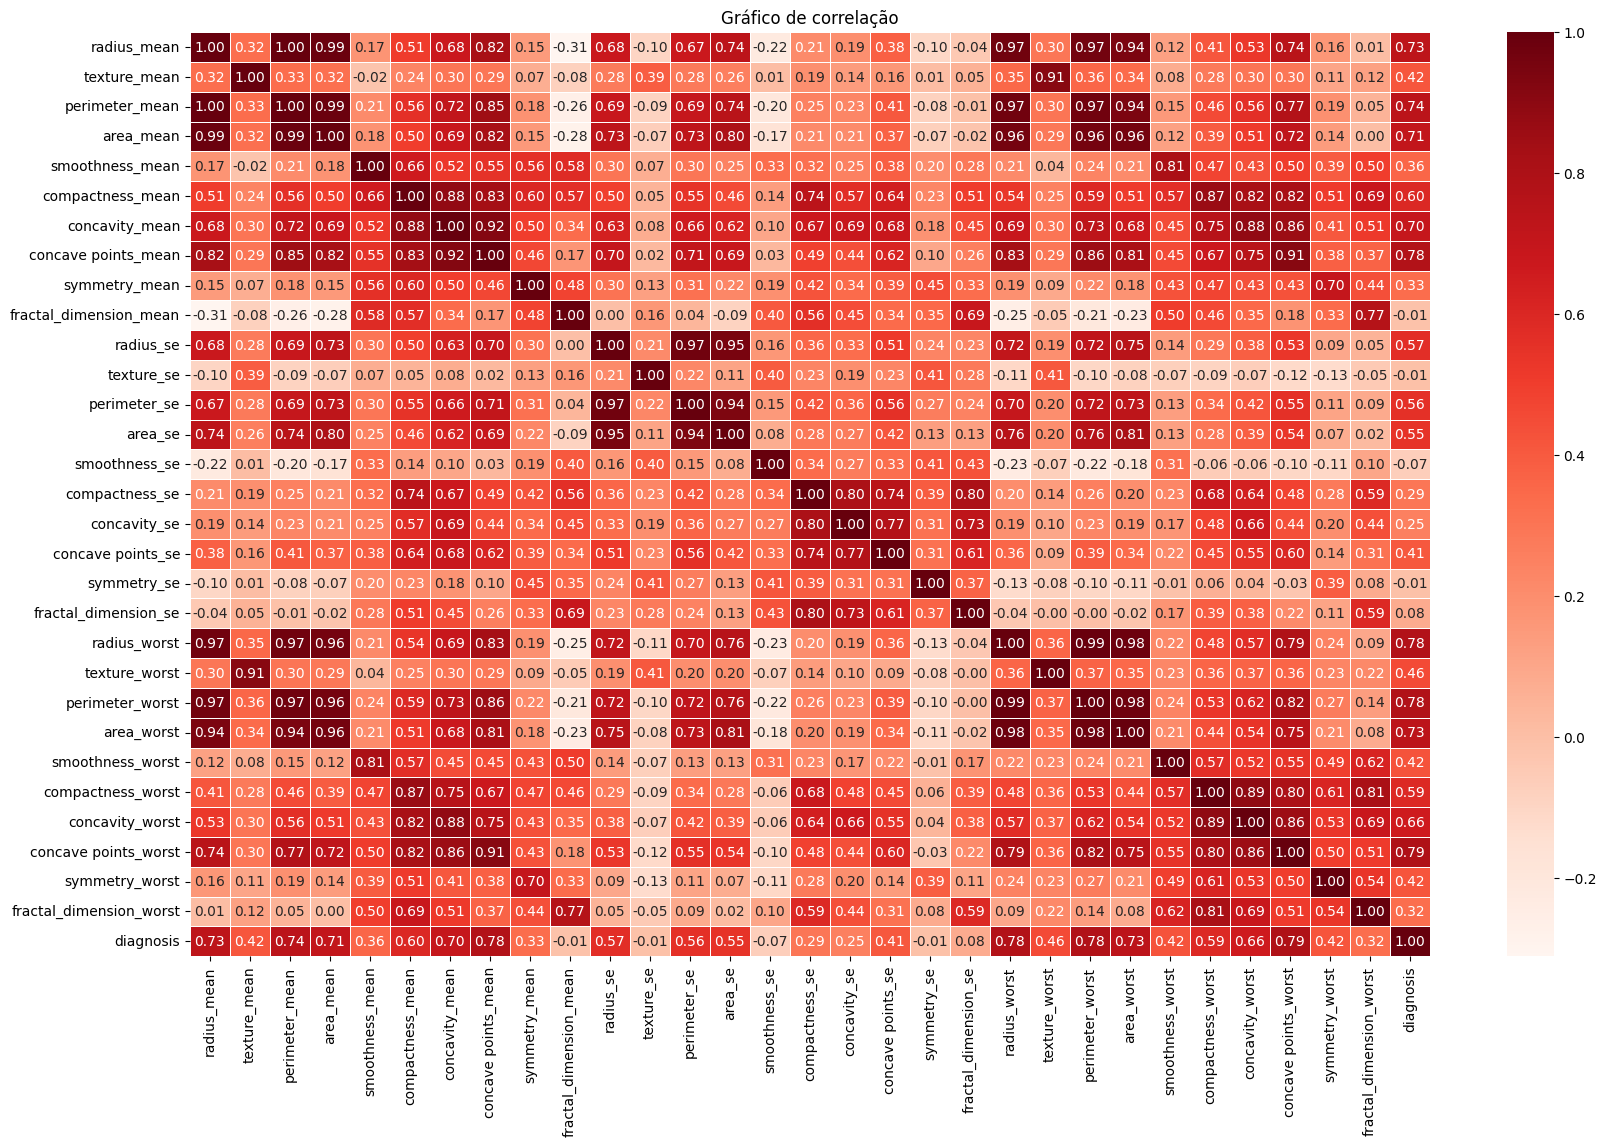

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', fmt=".2f", linewidths=.5)
plt.title("Gráfico de correlação")
plt.show()

Nesse gráfico podemos notar que existem muitos valores semelhantes em quantidade entre os valores, justamente da forma que havíamos discutido anteriormente, mas existem algumas correlações que sabemos exatamente como se comportam na vida real, como por exemplo, a correlação entre o raio, o perímetro e a área de um círculo perfeito, onde uma sempre aumentará a outra, que é o que gráfico também 
está indicando para nós

Vamos realizar um gráfico mais específico entre os valores "radius_mean", "perimeter_mean" e "area_mean" para entendermos como essas correlações estão ocorrendo?

array([[<Axes: xlabel='radius_mean', ylabel='radius_mean'>,
        <Axes: xlabel='perimeter_mean', ylabel='radius_mean'>,
        <Axes: xlabel='area_mean', ylabel='radius_mean'>],
       [<Axes: xlabel='radius_mean', ylabel='perimeter_mean'>,
        <Axes: xlabel='perimeter_mean', ylabel='perimeter_mean'>,
        <Axes: xlabel='area_mean', ylabel='perimeter_mean'>],
       [<Axes: xlabel='radius_mean', ylabel='area_mean'>,
        <Axes: xlabel='perimeter_mean', ylabel='area_mean'>,
        <Axes: xlabel='area_mean', ylabel='area_mean'>]], dtype=object)

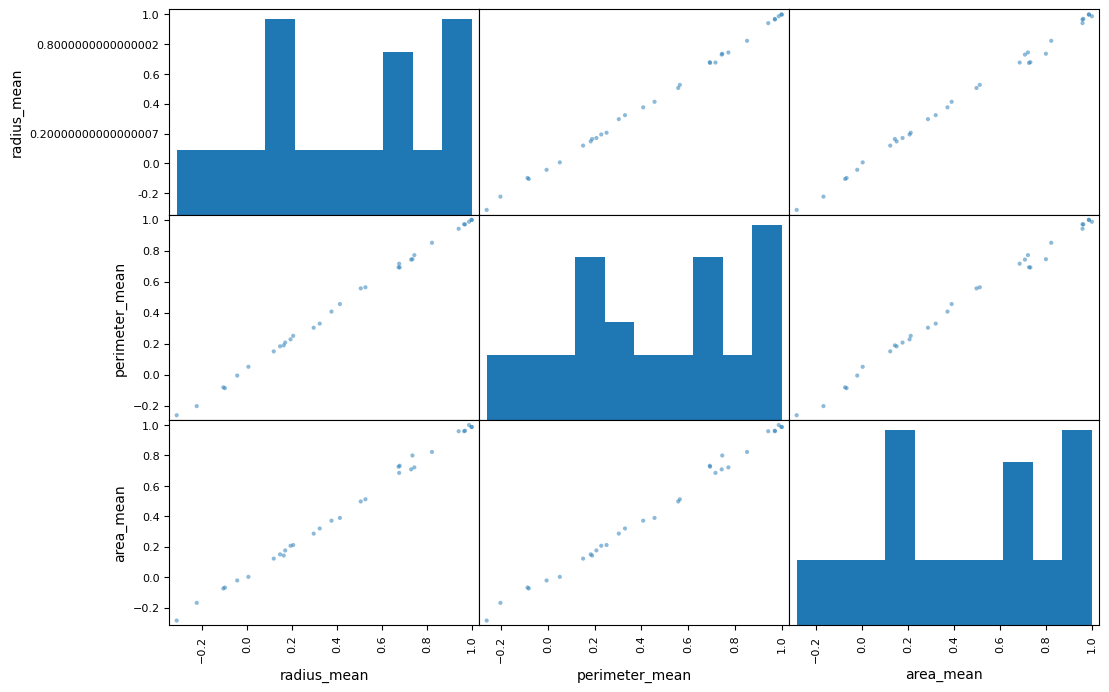

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["radius_mean", "perimeter_mean", "area_mean"]
scatter_matrix(corr_matrix[attributes], figsize=(12, 8))

Como dito anteriormente, penansdo em matemática, esses valores andam juntos em uma forma circular perfeita, e por conta disso. podemos ver que a medida que um deles aumenta, os outros também aumentam em conjunto, provando que esses valores foram descritos corretamente em nosso dataset

Em nosso caso específico, temos o interesse em saber, quando o nosso modelo irá marcar um diagnóstico para 0 (Benigno) ou 1 (Maligno), e para isso, podemos montar um gráfico para entendermos a correlação dos valores gerais com o nosso valor target que é "diagnosis"

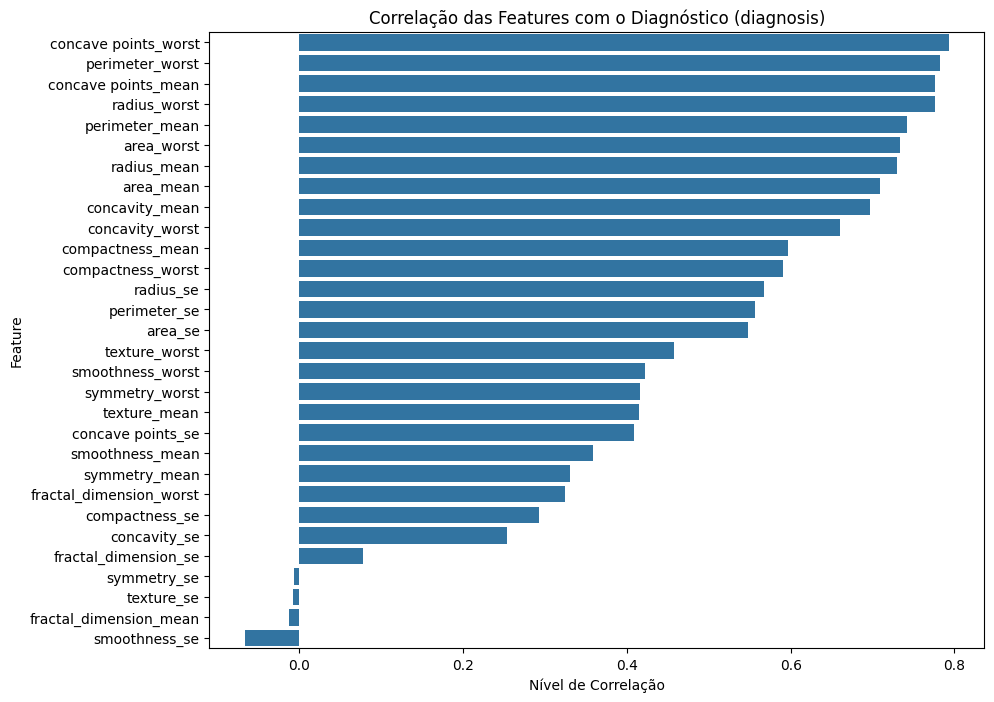

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
corr_without_target = corr_matrix[target_column].sort_values(ascending=False).drop(target_column)
sns.barplot(x=corr_without_target.values, y=corr_without_target.index)
plt.title(f'Correlação das Features com o Diagnóstico ({target_column})')
plt.xlabel('Nível de Correlação')
plt.ylabel('Feature')
plt.show()

Nesse gráfico, conseguimos entender que quanto maior os valores das variáveis, maior a chance do tumor ser maligno para o nosso diagnóstico, e também conseguimos notar que algumas variáveis como "smoothness_se", possuí uma importância invertida ao tumor maligno, ou seja, quanto maior esse valor, menos chance do tumor ser maligno

Bom, conseguimos tirar vários dados interessantes nesses testes que fizemos, mas agora chegamos a parte que interessa, vamos realizar a criação do nosso modelo

Configurando a pipeline de pré processamento dados

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)], remainder='passthrough')


Separando os dados treino e e teste

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Para enterdemos se a separação foi boa, podemos utilizar o comando abaixo para termos uma visualização

In [16]:
print(len(X_train), "treinamento +", len(X_test), "teste")

455 treinamento + 114 teste


Tivemos uma separação decente para o nosso modelo, porém, visto que os dados possuem um volume muito baixo, podemos ter alguns resultados inesperados futuramente, mas por agora, vamos dar continuidade à criação

Vamos dar início ao treinamento dos nossos modelos, para quesitos de teste, utilizarei 3 modelos diferentes, para entendermos como eles se comportam. Utilizarei a Regressão logística, a Árvore de decisões e o KNN

REGRESSÃO LOGÍSTICA

In [17]:
from sklearn.linear_model import LogisticRegression


model_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

model_reg_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Vamos availiar o modelo para utilizando a métrica Recall pois essa métrica pende bastante a evitar falsos negativos, onde o modelo diria que o paciente não possuí uma doença, mesmo ele tendo. Obviamente esse é o pior caso para a medicina, pois muitos pacientes não seriam tratados caso o modelo não tenha uma boa nota

In [18]:
from sklearn.metrics import recall_score

y_pred_reg = model_reg_pipeline.predict(X_test)
print(f"Recall: {recall_score(y_test, y_pred_reg, zero_division=0):.4f}")

Recall: 0.9524


Uma nota como essa é excelente para qualquer modelo, ainda mais para um modelo de diagnósticos médicos que criamos, porém, isso pode ser justamente por conta da quantidade baixa de dados que possuímos em nosso dataset, precisaríamos de uma quantidade muito maior para conseguirmos entender exatamente como ele foi, mas para um teste, essa nota é perfeita

Vamos criar um gráfico para entender melhor o quanto ele foi bem?

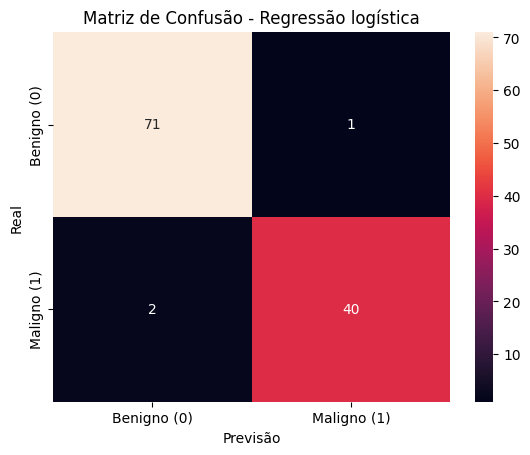

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


cm_reg = confusion_matrix(y_test, y_pred_reg)
sns.heatmap(cm_reg, annot=True, fmt='d',
            xticklabels=['Benigno (0)', 'Maligno (1)'],
            yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão logística')
plt.show()

Vamos entender esse gráfico, no canto superior esquerdo, temos a quantidade de acertos negativos do nosso modelo, 71, indicando quantas vezes ele identificou corretamente que o paciente não possuía uma doença.
No canto superior direito, temos justamente o contrário, quantas vezes ele pensou que o paciente possuía uma doença, mesmo ele não tendo, tivemos apenas 1 caso.
No canto inferior esquerdo, temos o mais perigoso, quantas vezes ele indicou que o paciente não possuía uma doença, mesmo ele tendo, tivemos 2 casos.
Por fim, temos o canto inferior direito, que indica os acertos positivos do nosso modelo, ou seja, quantas vezes ele informou corretamente que um paciente possuía a doença, tivemos 40 casos.

Apesar de ter ocorrido 2 casos onde ele indicou erroneamente que o paciente não possuía a doença, temos um modelo bastante decente para utilização, que estaria acertando a maioria dos casos, lembrando novamente que esse valor alto de acertos pode ser justamente por nossa base ser muito pequena para os testes, e o recomendado seria termos um novo teste, com uma base bem maior para termos um resultado justificativo.

Tudo parece muito bom, mas vamos ver como os outros modelos se saem?

ÁRVORE DE DECISÃO

In [20]:
from sklearn.tree import DecisionTreeClassifier


model_tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', DecisionTreeClassifier(random_state=42))])

model_tree_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Vamos availiar o modelo para utilizando o Roc Auc Score

In [21]:
from sklearn.metrics import recall_score


y_pred_tree = model_tree_pipeline.predict(X_test)
print(f"Recall: {recall_score(y_test, y_pred_tree):.4f}")


Recall: 0.9048


Vamos criar um gráfico para entender melhor o quanto ele foi bem?

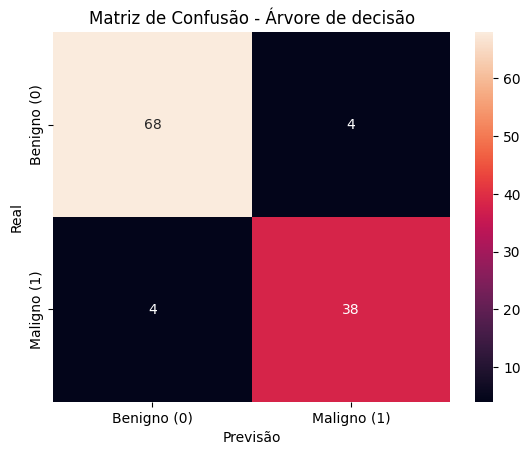

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d',
            xticklabels=['Benigno (0)', 'Maligno (1)'],
            yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de decisão')
plt.show()

KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier


model_knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', KNeighborsClassifier(n_neighbors=5))])
model_knn_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Vamos availiar o modelo para utilizando o Recall

In [24]:
from sklearn.metrics import recall_score


y_pred_knn = model_knn_pipeline.predict(X_test)

print(f"Recall: {recall_score(y_test, y_pred_knn):.4f}")

Recall: 0.9048


Vamos criar um gráfico para entender melhor o quanto ele foi bem?

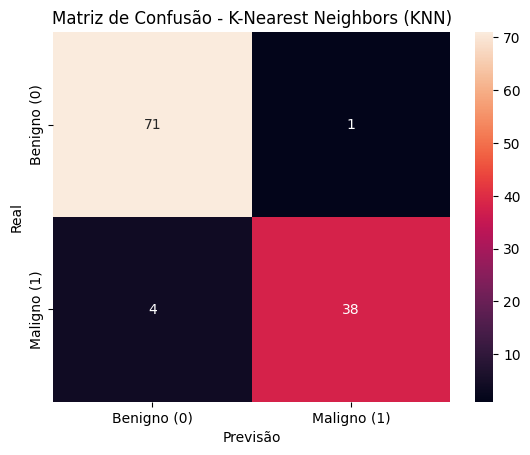

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d',
            xticklabels=['Benigno (0)', 'Maligno (1)'],
            yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - K-Nearest Neighbors (KNN)')
plt.show()

Ambos os modelos de Árvore de decisão e KNN, tiraram a mesma nota no Recall score de 90,4%, e tiveram 4 falhas críticas onde indicaram de forma incorreta, que o paciente não possuía a doença, porém, uma diferença a se notar é que no modelo de Árvore de decisão, também tivemos um número maior de falsos positivos, indicando que esse modelo não seria uma boa escolha para a nossa tarefa

No final ficamos com a Regressão logística em primeiro lugar, o KNN em segundo, e a Árvore de decisão em terceiro, e com base nisso poderíamos dizer que a Regressão logística, é o melhor modelo para esse exemplo, mas apesar disso, todos os modelos performaram muito bem, porém, para termos um modelo que possa ser utilizado profissionalmente um teste maior, com mais dados, e mais informações deve ser realizado em ordem de termos um resultado mais parecido com a realidade, onde temos diversos fatores que podem alterar o resultado final desse teste.